# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import sys
import numpy
import math
numpy.set_printoptions(threshold=sys.maxsize)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
import tensorflow as tf
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

import shap

2022-01-07 14:06:20.543186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-07 14:06:20.543219: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load pre porcessed data
df = pd.read_csv('../prepross_data/data.csv')


#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


### for SH events prediction pre processing


In [4]:
y_label = 'Pt_SevHypoEver' 
# possible labels Pt_SevHypoEver, SHSeizComaPast12mos, DKAPast12mos, Depression, DiabNeuro, DKADiag

In [5]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['Pt_SevHypoEver'])):
        if(row['NumSHSeizComaPast12mos'] >= 1) or (row['Pt_v3NumSHSeizComa'] >= 1) or (row['SHSeizComaPast12mos'] == 0):
            row['Pt_SevHypoEver'] = 0
        else:
            row['Pt_SevHypoEver'] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [6]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# {'1.Yes': 0, '2.No': 1, "3.Don't know": 2}

get_possible_vals_with_nan(df, y_label)

if(y_label == 'SHSeizComaPast12mos' ):
#     df.drop(['NumSHSeizComaPast12mos','Pt_v3NumSHSeizComa','NumSHSeizComa', 'Pt_SevHypoEver'], inplace=True, axis=1) # add SHSeizComaPast12mos
    df.drop(['NumSHSeizComaPast12mos','Pt_v3NumSHSeizComa'], inplace=True, axis=1) # add SHSeizComaPast12mos
    df[y_label] = df[y_label].replace({2.0: 1.0})

elif (y_label == 'Pt_SevHypoEver'):
#     df.drop(['NumSHSeizComaPast12mos','Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1) # add SHSeizComaPast12mos
    df[y_label] = df[y_label].replace({2.0: 0.0})


# Divide Dataset

In [7]:
# filter only the features used in paper diagDuration,

selected_features = True

# if(selected_features):
#     df = df[['AgeAtConsent','diagDuration','HbA1c', 'Gender', 'Pt_RaceEth','Pt_AnnualInc', 'Pt_InsPriv', 'Pt_EduLevel',
#          'InsulinDeliv','Pt_InsCarbRat', 'relative_T1D', 'Pt_Smoke', y_label,
#          'MajorLifeStressEvent', 'Weight', 'Height']] # Pt_SevHypoEver ,SHSeizComaPast12mos, DKAPast12mos

if(selected_features):
    df = df[['diagDuration','HbA1c','Pt_AnnualInc', 'Pt_InsPriv', 'education_level',
         'InsulinDeliv', 'Pt_Smoke', y_label,
             'Pt_InsCarbRat', 
             'relative_T1D'
#          'MajorLifeStressEvent'
            ]] # Pt_SevHypoEver ,SHSeizComaPast12mos, DKAPast12mos


# if(selected_features):
#     df = df[['Diab_dur_greater','HbA1C_SH','Pt_AnnualInc', 'Pt_InsPriv', 'Pt_EduLevel','diagDuration'
#              ,y_label]] # SHSeizComaPast12mos



In [8]:
if(not selected_features):
    df=df.drop('PtID', axis = 1)

<AxesSubplot:>

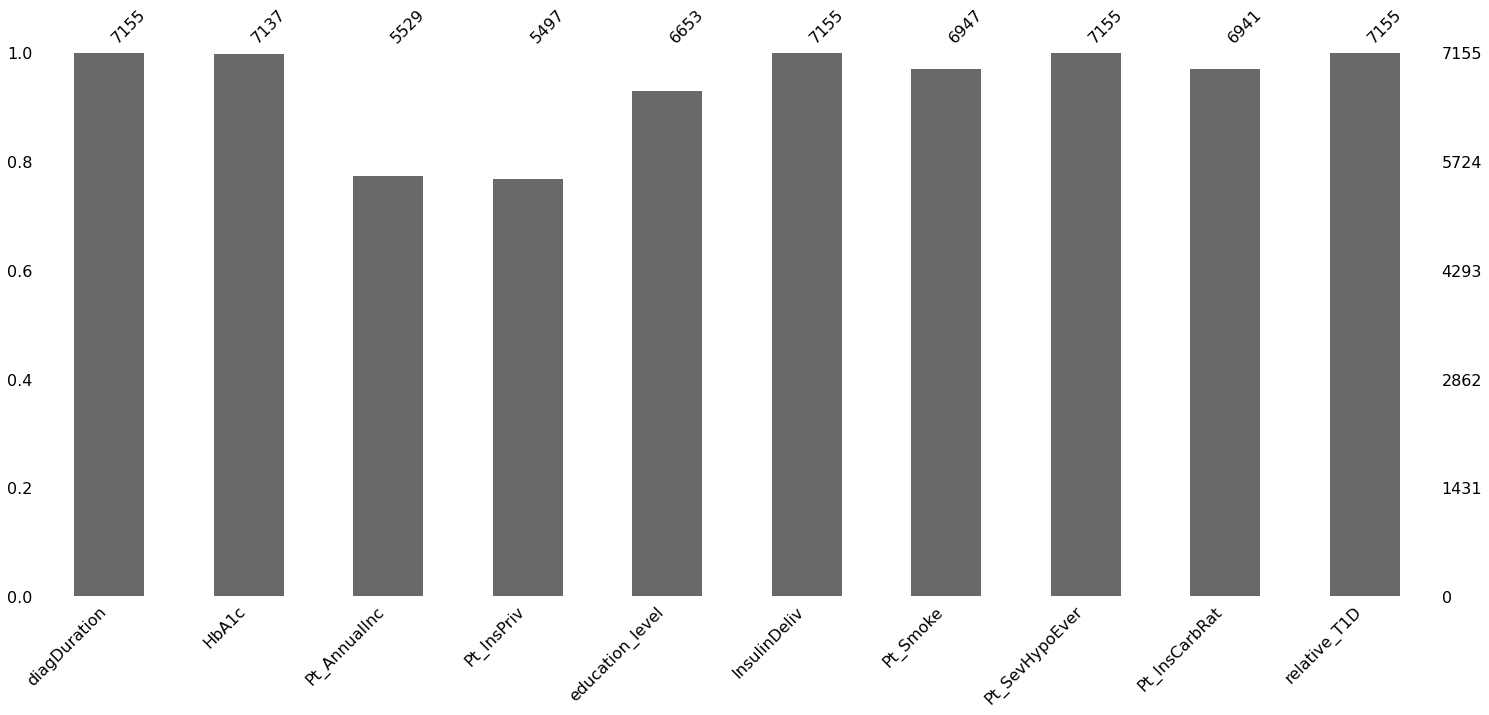

In [9]:
import missingno as msno
msno.bar(df)

In [10]:
df['Pt_InsPriv'] = df['Pt_InsPriv'].fillna(0)
df['Pt_InsPriv'].unique()

array([1., 0.])

> with imputation gives little more better results than dropping the rows if there are null values

In [11]:
# df = df.dropna()
# df

In [12]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y


X, Y = divide_data(df, y_label)


In [13]:
# pd.set_option('display.max_columns', None)  # or 1000
# pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', -1)  # or 199



# Feature Selection

In [14]:
shape = np.shape(X) 

if(selected_features):
    feature = shape[1] 
else:
    feature = shape[1] 
    
n_classes = 2

feature

9

In [15]:

# fill with 0 - if data not available probably patient has not that medical condition
if(y_label == 'SHSeizComaPast12mos' or y_label == 'DKADiag' or y_label == 'Pt_SevHypoEver' or y_label == 'DKAPast12mos'):
    Y = Y.fillna(1)
else:
    Y = Y.fillna(0)


In [16]:

seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)
# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [17]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print(unique, counts)


unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print(unique_test, counts_test)


[0. 1.] [1548 3818]
[0. 1.] [ 516 1273]


In [18]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [19]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val_with_missing_val(model):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train.columns]
#         X_test1 = train.iloc[test_index][X_train.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model



    dfs = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    return model



### XGB with missing values

Accuracy for the fold no. 1 on the test set: 0.7113594040968343, doublecheck: 0.7113594040968343
Accuracy for the fold no. 2 on the test set: 0.702048417132216, doublecheck: 0.702048417132216
Accuracy for the fold no. 3 on the test set: 0.7039106145251397, doublecheck: 0.7039106145251397
Accuracy for the fold no. 4 on the test set: 0.7243947858472998, doublecheck: 0.7243947858472998
Accuracy for the fold no. 5 on the test set: 0.6964618249534451, doublecheck: 0.6964618249534451
Accuracy for the fold no. 6 on the test set: 0.6945996275605214, doublecheck: 0.6945996275605214
Accuracy for the fold no. 7 on the test set: 0.7089552238805971, doublecheck: 0.7089552238805971
Accuracy for the fold no. 8 on the test set: 0.7014925373134329, doublecheck: 0.7014925373134329
Accuracy for the fold no. 9 on the test set: 0.7164179104477612, doublecheck: 0.7164179104477612
Accuracy for the fold no. 10 on the test set: 0.7201492537313433, doublecheck: 0.7201492537313433

 
 ===========   Train Dataset

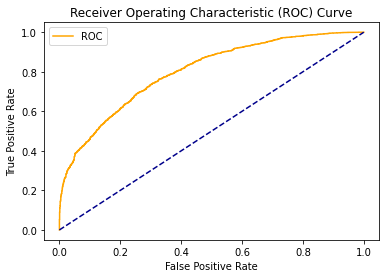

accuracy score:  73.68617219530377
              precision    recall  f1-score   support

         0.0       0.53      0.67      0.60      1548
         1.0       0.85      0.76      0.80      3818

    accuracy                           0.74      5366
   macro avg       0.69      0.72      0.70      5366
weighted avg       0.76      0.74      0.74      5366



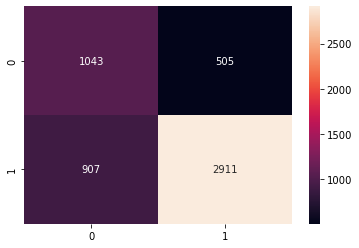

Accuracy of XGB on training set: 0.76


 ===========   Test Dataset    =============
Threshold value is: 0.9920324


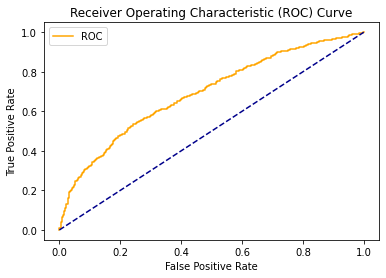

accuracy score:  59.92174399105645
              precision    recall  f1-score   support

         0.0       0.40      0.76      0.52       516
         1.0       0.85      0.53      0.65      1273

    accuracy                           0.60      1789
   macro avg       0.62      0.65      0.59      1789
weighted avg       0.72      0.60      0.62      1789



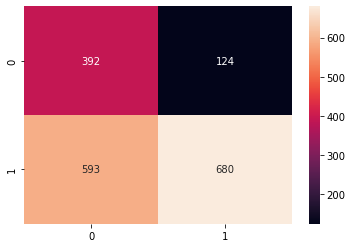

Accuracy of XGB classifier on test set: 0.72


 ===========   ROC    =============
roc_auc = 0.6911


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.75968992 0.53417125]
average accuracy:  0.6469305857493439
f1 0.6547905633124699


In [20]:
# xgboost - train with missing values
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

model=XGBClassifier(
        use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
#         scale_pos_weight = 0.4,
#         n_jobs = 0,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test))

<AxesSubplot:>

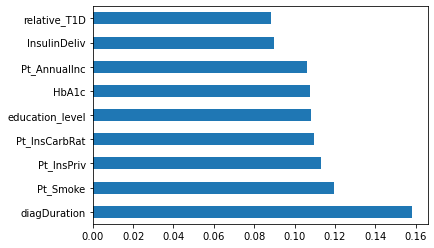

In [21]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:162])
feat_importances.nlargest(20).plot(kind='barh')

# Imputations

In [22]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
# imputeX = IterativeImputer(max_iter=5, random_state=0)

X_train = imputeX.fit_transform(X_train)


In [23]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)


# Scale data

In [24]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
select[0] = pd.DataFrame(scaler.fit_transform(X_train))
select[1] = Y_train
select[2] = pd.DataFrame(scaler.transform(X_test))

# Feature selection

In [25]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [26]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])
        
    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [27]:
# Feature selection
selected, fs, idx = select_features(select, feature)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:07:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [28]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)

Index(['diagDuration', 'HbA1c', 'Pt_AnnualInc', 'Pt_InsPriv',
       'education_level', 'InsulinDeliv', 'Pt_Smoke', 'Pt_InsCarbRat',
       'relative_T1D'],
      dtype='object')
(7155, 9)


In [29]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)

In [30]:
X_train

,diagDuration,HbA1c,Pt_AnnualInc,Pt_InsPriv,education_level,InsulinDeliv,Pt_Smoke,Pt_InsCarbRat,relative_T1D
0,1.015010,1.133667,-1.063759,-1.827956,0.349203,-0.726216,-0.617657,-0.452044,-0.622318
1,0.109434,-0.614464,0.458511,0.547059,-0.267999,2.242832,-0.617657,-0.452044,-0.622318
2,-0.847079,-0.052073,0.839078,0.547059,1.583607,-0.726216,-0.617657,-0.452044,1.606894
3,-0.647471,-0.015621,-0.302624,0.547059,0.349203,-0.726216,-0.617657,-0.452044,-0.622318
4,-0.676472,-0.832130,1.600213,-1.827956,0.349203,0.758308,-0.617657,-0.452044,-0.622318
...,...,...,...,...,...,...,...,...,...
5361,1.036058,0.803461,-0.302624,0.547059,0.349203,-0.726216,-0.617657,-0.452044,-0.622318
5362,-0.285271,-1.736123,-1.063759,0.547059,0.349203,-0.726216,-0.617657,-0.452044,1.606894
5363,-0.172622,0.097503,-1.063759,0.547059,-0.267999,-0.726216,-0.617657,4.019230,-0.622318
5364,-0.066351,0.222969,1.219646,-1.827956,0.966405,0.758308,1.278422,-0.452044,-0.622318


## Common Functions

In [31]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val(model):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train.columns]
#         X_ test1 = train.iloc[test_index][X_train.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model



    dfs = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    return model



In [32]:
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    print(roc_auc_score(Y, y_scores))
#     optimal_idx = np.argmax(sqrt(tpr * (1-fpr)))
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr)
    plt.show()
    return optimal_threshold

In [33]:
def train_results(model, X_train, Y_train, pred_train):
    print("\n \n =====================   Train Dataset    ======================")

    print(accuracy_score(Y_train, pred_train)*100)

    confusion_matrix_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
    sns.heatmap(confusion_matrix_train, annot=True,fmt='g')
    print(classification_report(Y_train, pred_train))
    plt.show()
    
    train_acc = model.score(X_train, Y_train)
    print('Accuracy of on training set: {:.2f}'.format(train_acc))

def test_results(model, X_test, Y_test, pred):
    print("\n\n =====================   Test Dataset    =======================")

    print(accuracy_score(Y_test, pred)*100)

    confusion_matrix_model = confusion_matrix(Y_test, pred)
    sns.heatmap(confusion_matrix_model, annot=True,fmt='g')
    print(classification_report(Y_test, pred))
    plt.show()
    
    test_acc = model.score(X_test, Y_test)
    print('Accuracy of classifier on test set: {:.2f}'
         .format(test_acc))

def ROC_results(model, X_test, Y_test):
    print("\n\n =======================   Test-ROC    =========================")

    y_scores = model.predict_proba(X_test)
    score = roc_auc_score(Y_test, y_scores[:, 1])
    score = round(score,4)
    print(f'roc_auc = {score}')
    
def class_wise_test_accuracy(model, Y_test, pred):
    print("\n\n =======================   Class-wise test accuracy    =====================")
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal()/confusion_matrix_model.sum(axis=1)
    print('classwise accuracy [class 0, class 1]: ',(acc))
    print('average accuracy: ',( np.sum(acc)/2))

### Adaboost model

Accuracy for the fold no. 1 on the test set: 0.7206703910614525, doublecheck: 0.7206703910614525
Accuracy for the fold no. 2 on the test set: 0.7039106145251397, doublecheck: 0.7039106145251397
Accuracy for the fold no. 3 on the test set: 0.7243947858472998, doublecheck: 0.7243947858472998
Accuracy for the fold no. 4 on the test set: 0.7188081936685289, doublecheck: 0.7188081936685289
Accuracy for the fold no. 5 on the test set: 0.7132216014897579, doublecheck: 0.7132216014897579
Accuracy for the fold no. 6 on the test set: 0.7113594040968343, doublecheck: 0.7113594040968343
Accuracy for the fold no. 7 on the test set: 0.7089552238805971, doublecheck: 0.7089552238805971
Accuracy for the fold no. 8 on the test set: 0.7052238805970149, doublecheck: 0.7052238805970149
Accuracy for the fold no. 9 on the test set: 0.7164179104477612, doublecheck: 0.7164179104477612
Accuracy for the fold no. 10 on the test set: 0.7220149253731343, doublecheck: 0.7220149253731343
Train ROC
0.6939695925596556


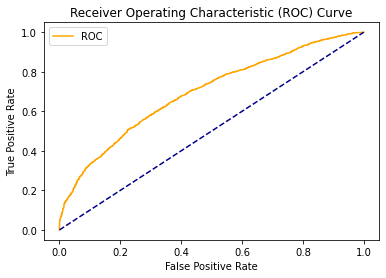

Test ROC
0.6911358141970685
Threshold value is: 0.5044507270472397


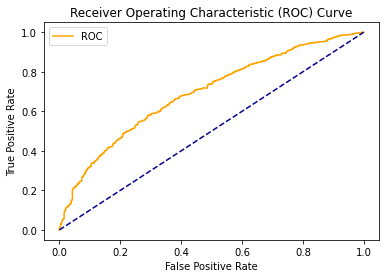


 
 =====================   Train Dataset    ======================
61.49832277301528
              precision    recall  f1-score   support

         0.0       0.40      0.70      0.51      1548
         1.0       0.83      0.58      0.68      3818

    accuracy                           0.61      5366
   macro avg       0.62      0.64      0.60      5366
weighted avg       0.71      0.61      0.63      5366



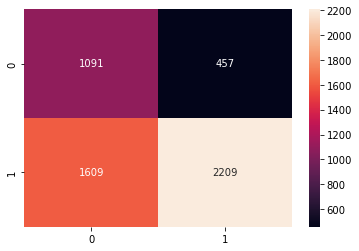

Accuracy of on training set: 0.72


 =====================   Test Dataset    =======================
61.71045276690889
              precision    recall  f1-score   support

         0.0       0.41      0.71      0.52       516
         1.0       0.83      0.58      0.68      1273

    accuracy                           0.62      1789
   macro avg       0.62      0.64      0.60      1789
weighted avg       0.71      0.62      0.64      1789



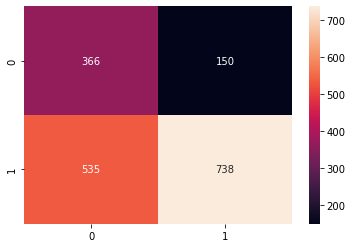

Accuracy of classifier on test set: 0.72


 =======================   Test-ROC    =========================
roc_auc = 0.6911


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.70930233 0.57973291]
average accuracy:  0.6445176199784433


In [34]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

adaboost = AdaBoostClassifier(random_state=0, learning_rate=0.05, n_estimators=1000, algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# adaboost.fit(X_train, Y_train)
adaboost = cross_val(adaboost)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(adaboost, X_train, Y_train)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(adaboost, X_test, Y_test)
pred = (adaboost.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(adaboost, X_train, Y_train, pred_train)
test_results(adaboost, X_test, Y_test, pred)

# ROC
ROC_results(adaboost, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(adaboost, Y_test, pred)


<AxesSubplot:>

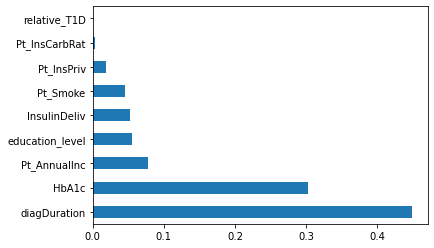

In [35]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(feature).plot(kind='barh')

# Model - XGB

Accuracy for the fold no. 1 on the test set: 0.7094972067039106, doublecheck: 0.7094972067039106
Accuracy for the fold no. 2 on the test set: 0.702048417132216, doublecheck: 0.702048417132216
Accuracy for the fold no. 3 on the test set: 0.7039106145251397, doublecheck: 0.7039106145251397
Accuracy for the fold no. 4 on the test set: 0.7243947858472998, doublecheck: 0.7243947858472998
Accuracy for the fold no. 5 on the test set: 0.6983240223463687, doublecheck: 0.6983240223463687
Accuracy for the fold no. 6 on the test set: 0.7039106145251397, doublecheck: 0.7039106145251397
Accuracy for the fold no. 7 on the test set: 0.7052238805970149, doublecheck: 0.7052238805970149
Accuracy for the fold no. 8 on the test set: 0.7089552238805971, doublecheck: 0.7089552238805971
Accuracy for the fold no. 9 on the test set: 0.7164179104477612, doublecheck: 0.7164179104477612
Accuracy for the fold no. 10 on the test set: 0.7145522388059702, doublecheck: 0.7145522388059702
Train ROC
0.7940320432386777
Th

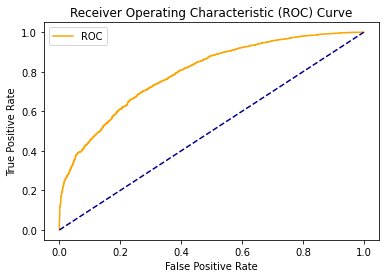

Test ROC
0.6789385386409446
Threshold value is: 1.0194733


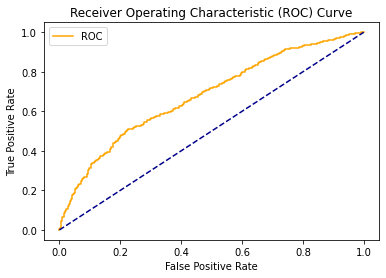


 
 =====================   Train Dataset    ======================
70.27581065970928
              precision    recall  f1-score   support

         0.0       0.49      0.74      0.59      1548
         1.0       0.87      0.69      0.77      3818

    accuracy                           0.70      5366
   macro avg       0.68      0.71      0.68      5366
weighted avg       0.76      0.70      0.72      5366



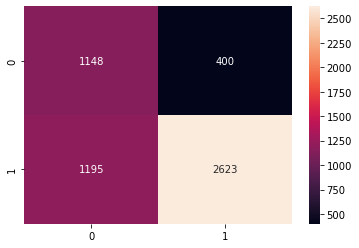

Accuracy of on training set: 0.76


 =====================   Test Dataset    =======================
58.46841811067635
              precision    recall  f1-score   support

         0.0       0.39      0.78      0.52       516
         1.0       0.85      0.51      0.63      1273

    accuracy                           0.58      1789
   macro avg       0.62      0.64      0.58      1789
weighted avg       0.72      0.58      0.60      1789



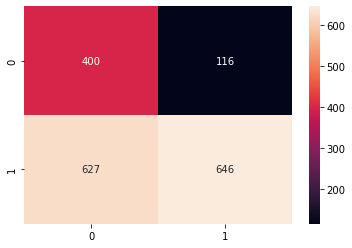

Accuracy of classifier on test set: 0.71


 =======================   Test-ROC    =========================
roc_auc = 0.6789


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.7751938  0.50746269]
average accuracy:  0.6413282425083884


In [36]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
# xgb_impute.fit(X_train,Y_train)
xgb_impute = cross_val(xgb_impute)

# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)


# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(xgb_impute, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(xgb_impute, X_test, Y_test)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(xgb_impute, X_train, Y_train, xgb_pred_train)
test_results(xgb_impute, X_test, Y_test, xgb_pred)

# ROC
ROC_results(xgb_impute, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(xgb_impute, Y_test, xgb_pred)



<AxesSubplot:>

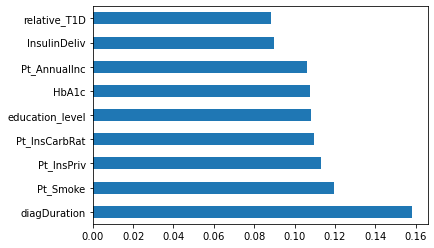

In [37]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 2 - Random forest

Accuracy for the fold no. 1 on the test set: 0.5996275605214153, doublecheck: 0.5996275605214153
Accuracy for the fold no. 2 on the test set: 0.6312849162011173, doublecheck: 0.6312849162011173
Accuracy for the fold no. 3 on the test set: 0.6219739292364991, doublecheck: 0.6219739292364991
Accuracy for the fold no. 4 on the test set: 0.6294227188081937, doublecheck: 0.6294227188081937
Accuracy for the fold no. 5 on the test set: 0.6163873370577281, doublecheck: 0.6163873370577281
Accuracy for the fold no. 6 on the test set: 0.633147113594041, doublecheck: 0.633147113594041
Accuracy for the fold no. 7 on the test set: 0.6082089552238806, doublecheck: 0.6082089552238806
Accuracy for the fold no. 8 on the test set: 0.6119402985074627, doublecheck: 0.6119402985074627
Accuracy for the fold no. 9 on the test set: 0.6623134328358209, doublecheck: 0.6623134328358209
Accuracy for the fold no. 10 on the test set: 0.6772388059701493, doublecheck: 0.6772388059701493
Train ROC
0.8207103777428555
Th

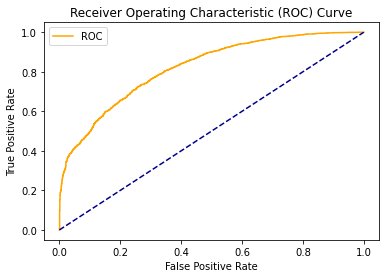

Test ROC
0.6817975605448888
Threshold value is: 0.5204454261564877


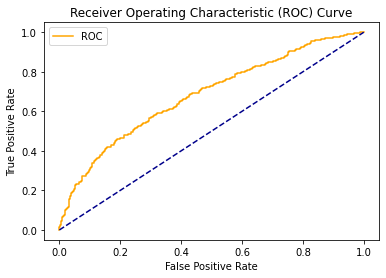


 
 =====================   Train Dataset    ======================
73.01528140141632
              precision    recall  f1-score   support

         0.0       0.52      0.74      0.61      1548
         1.0       0.87      0.73      0.79      3818

    accuracy                           0.73      5366
   macro avg       0.70      0.73      0.70      5366
weighted avg       0.77      0.73      0.74      5366



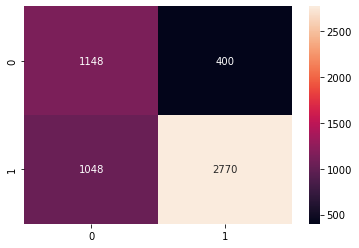

Accuracy of on training set: 0.72


 =====================   Test Dataset    =======================
61.37506987143656
              precision    recall  f1-score   support

         0.0       0.40      0.69      0.51       516
         1.0       0.82      0.58      0.68      1273

    accuracy                           0.61      1789
   macro avg       0.61      0.64      0.59      1789
weighted avg       0.70      0.61      0.63      1789



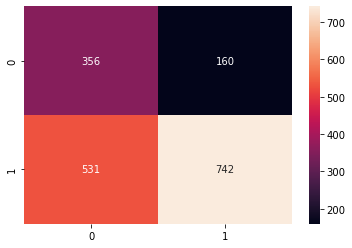

Accuracy of classifier on test set: 0.62


 =======================   Test-ROC    =========================
roc_auc = 0.6818


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.68992248 0.5828751 ]
average accuracy:  0.6363987894066997


In [38]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=10,
#                              n_estimators = feature,
                             criterion = 'entropy', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced_subsample', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.001,
                             random_state=0)

# rf.fit(X_train,Y_train)
rf = cross_val(rf)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(rf, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(rf, X_test, Y_test)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(rf, X_train, Y_train, pred_train)
test_results(rf, X_test, Y_test, pred)

# ROC
ROC_results(rf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(rf, Y_test, pred)

<AxesSubplot:>

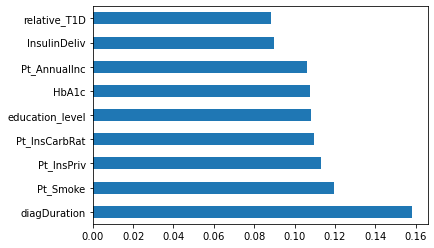

In [39]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 3 LogisticRegression

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 1 on the test set: 0.6238361266294227, doublecheck: 0.6238361266294227
Accuracy for the fold no. 2 on the test set: 0.6312849162011173, doublecheck: 0.6312849162011173
Accuracy for the fold no. 3 on the test set: 0.6163873370577281, doublecheck: 0.6163873370577281
Accuracy for the fold no. 4 on the test set: 0.6219739292364991, doublecheck: 0.6219739292364991
Accuracy for the fold no. 5 on the test set: 0.6294227188081937, doublecheck: 0.6294227188081937
Accuracy for the fold no. 6 on the test set: 0.6350093109869647, doublecheck: 0.6350093109869647


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 7 on the test set: 0.6082089552238806, doublecheck: 0.6082089552238806
Accuracy for the fold no. 8 on the test set: 0.621268656716418, doublecheck: 0.621268656716418
Accuracy for the fold no. 9 on the test set: 0.6716417910447762, doublecheck: 0.6716417910447762
Accuracy for the fold no. 10 on the test set: 0.664179104477612, doublecheck: 0.664179104477612
Train ROC
0.6758555962982364
Threshold value is: 0.5383839230190658


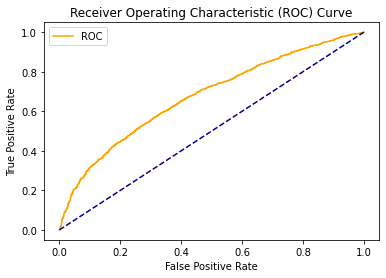

Test ROC
0.6894003056930769
Threshold value is: 0.540089328951793


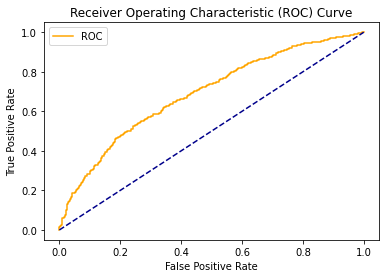


 
 =====================   Train Dataset    ======================
60.305628028326495
              precision    recall  f1-score   support

         0.0       0.39      0.69      0.50      1548
         1.0       0.82      0.57      0.67      3818

    accuracy                           0.60      5366
   macro avg       0.61      0.63      0.59      5366
weighted avg       0.70      0.60      0.62      5366



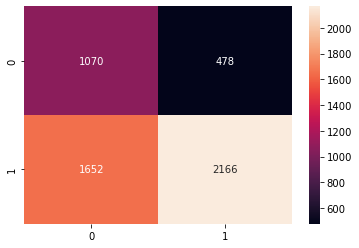

Accuracy of on training set: 0.64


 =====================   Test Dataset    =======================
59.53046394633874
              precision    recall  f1-score   support

         0.0       0.39      0.75      0.52       516
         1.0       0.84      0.53      0.65      1273

    accuracy                           0.60      1789
   macro avg       0.62      0.64      0.58      1789
weighted avg       0.71      0.60      0.61      1789



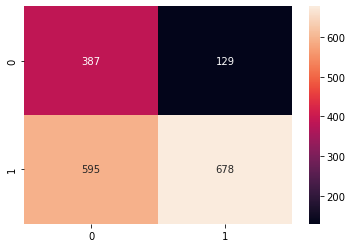

Accuracy of classifier on test set: 0.63


 =======================   Test-ROC    =========================
roc_auc = 0.6894


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.75       0.53260016]
average accuracy:  0.6413000785545955


In [40]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# logreg.fit(X_train, Y_train)
logreg = cross_val(logreg)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(logreg, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(logreg, X_test, Y_test)

pred = (logreg.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(logreg, X_train, Y_train, pred_train)
test_results(logreg, X_test, Y_test, pred)

# ROC
ROC_results(logreg, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(logreg, Y_test, pred)

<AxesSubplot:>

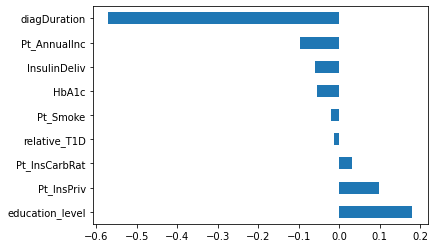

In [41]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 4 - Decision tree

Accuracy for the fold no. 1 on the test set: 0.6350093109869647, doublecheck: 0.6350093109869647
Accuracy for the fold no. 2 on the test set: 0.6108007448789572, doublecheck: 0.6108007448789572
Accuracy for the fold no. 3 on the test set: 0.6014897579143389, doublecheck: 0.6014897579143389
Accuracy for the fold no. 4 on the test set: 0.6312849162011173, doublecheck: 0.6312849162011173
Accuracy for the fold no. 5 on the test set: 0.6256983240223464, doublecheck: 0.6256983240223464
Accuracy for the fold no. 6 on the test set: 0.6126629422718808, doublecheck: 0.6126629422718808
Accuracy for the fold no. 7 on the test set: 0.6436567164179104, doublecheck: 0.6436567164179104
Accuracy for the fold no. 8 on the test set: 0.5970149253731343, doublecheck: 0.5970149253731343
Accuracy for the fold no. 9 on the test set: 0.6380597014925373, doublecheck: 0.6380597014925373
Accuracy for the fold no. 10 on the test set: 0.6548507462686567, doublecheck: 0.6548507462686567
Train ROC
0.9573369311421621


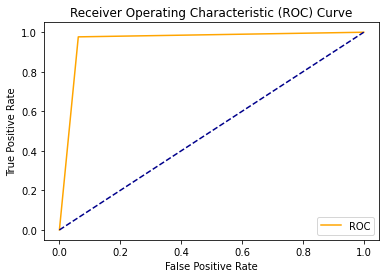

Test ROC
0.5593642862797397
Threshold value is: 1.0


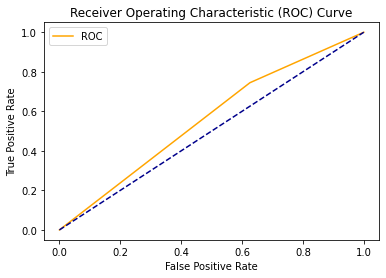


 
 =====================   Train Dataset    ======================
96.55236675363399
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      1548
         1.0       0.97      0.98      0.98      3818

    accuracy                           0.97      5366
   macro avg       0.96      0.96      0.96      5366
weighted avg       0.97      0.97      0.97      5366



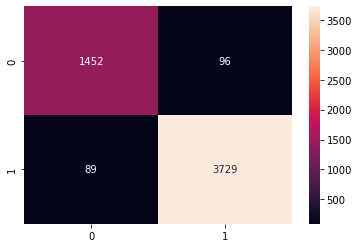

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
63.77864728898827
              precision    recall  f1-score   support

         0.0       0.37      0.37      0.37       516
         1.0       0.75      0.74      0.75      1273

    accuracy                           0.64      1789
   macro avg       0.56      0.56      0.56      1789
weighted avg       0.64      0.64      0.64      1789



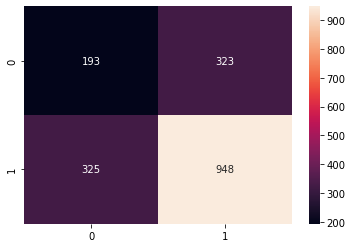

Accuracy of classifier on test set: 0.64


 =======================   Test-ROC    =========================
roc_auc = 0.5594


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.37403101 0.74469756]
average accuracy:  0.5593642862797397


In [42]:
clf = DecisionTreeClassifier(
                        random_state=0,
                        criterion='gini',
                        splitter = 'best',
                        max_depth = 100,
                        max_features = 5)
# clf.fit(X_train, Y_train)
clf = cross_val(clf)

# pred=clf.predict(X_test)
# pred_train=clf.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(clf, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(clf, X_test, Y_test)

pred = (clf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (clf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(clf, X_train, Y_train, pred_train)
test_results(clf, X_test, Y_test, pred)

# ROC
ROC_results(clf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(clf, Y_test, pred)

<AxesSubplot:>

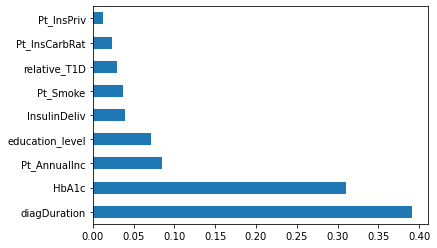

In [43]:

feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 5 - K-Nearest Neighbors

Accuracy for the fold no. 1 on the test set: 0.6033519553072626, doublecheck: 0.6033519553072626
Accuracy for the fold no. 2 on the test set: 0.6238361266294227, doublecheck: 0.6238361266294227
Accuracy for the fold no. 3 on the test set: 0.633147113594041, doublecheck: 0.633147113594041
Accuracy for the fold no. 4 on the test set: 0.5642458100558659, doublecheck: 0.5642458100558659
Accuracy for the fold no. 5 on the test set: 0.6368715083798883, doublecheck: 0.6368715083798883
Accuracy for the fold no. 6 on the test set: 0.6126629422718808, doublecheck: 0.6126629422718808
Accuracy for the fold no. 7 on the test set: 0.6268656716417911, doublecheck: 0.6268656716417911
Accuracy for the fold no. 8 on the test set: 0.6343283582089553, doublecheck: 0.6343283582089553
Accuracy for the fold no. 9 on the test set: 0.6361940298507462, doublecheck: 0.6361940298507462
Accuracy for the fold no. 10 on the test set: 0.6063432835820896, doublecheck: 0.6063432835820896
Train ROC
0.951051425114005
Thr

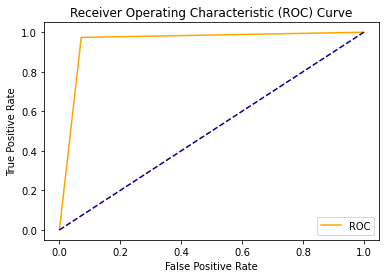

Test ROC
0.5379946960424317
Threshold value is: 1.0


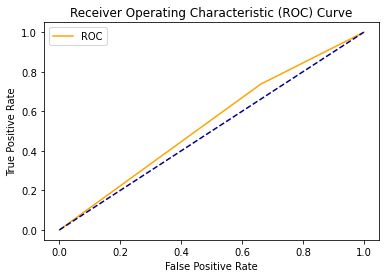


 
 =====================   Train Dataset    ======================
96.06783451360418
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      1548
         1.0       0.97      0.97      0.97      3818

    accuracy                           0.96      5366
   macro avg       0.95      0.95      0.95      5366
weighted avg       0.96      0.96      0.96      5366



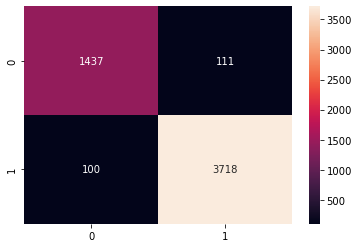

Accuracy of on training set: 0.96


 =====================   Test Dataset    =======================
62.21352711011738
              precision    recall  f1-score   support

         0.0       0.34      0.34      0.34       516
         1.0       0.73      0.74      0.74      1273

    accuracy                           0.62      1789
   macro avg       0.54      0.54      0.54      1789
weighted avg       0.62      0.62      0.62      1789



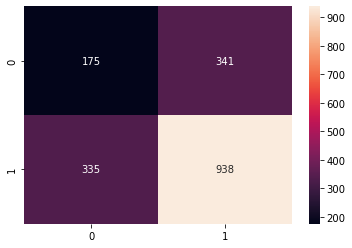

Accuracy of classifier on test set: 0.62


 =======================   Test-ROC    =========================
roc_auc = 0.538


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.33914729 0.73684211]
average accuracy:  0.5379946960424317


In [44]:
knn = KNeighborsClassifier(
    n_neighbors =1,
    weights = "uniform", # uniform, distance
    algorithm =  'brute', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
)

# knn.fit(X_train, Y_train)
knn = cross_val(knn)

# pred=knn.predict(X_test)
# pred_train=knn.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(knn, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(knn, X_test, Y_test)

pred = (knn.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (knn.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(knn, X_train, Y_train, pred_train)
test_results(knn, X_test, Y_test, pred)

# ROC
ROC_results(knn, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(knn, Y_test, pred)

## Model 6 - Linear Discriminant Analysis

Accuracy for the fold no. 1 on the test set: 0.7169459962756052, doublecheck: 0.7169459962756052
Accuracy for the fold no. 2 on the test set: 0.702048417132216, doublecheck: 0.702048417132216
Accuracy for the fold no. 3 on the test set: 0.7094972067039106, doublecheck: 0.7094972067039106
Accuracy for the fold no. 4 on the test set: 0.7225325884543762, doublecheck: 0.7225325884543762
Accuracy for the fold no. 5 on the test set: 0.7150837988826816, doublecheck: 0.7150837988826816
Accuracy for the fold no. 6 on the test set: 0.7057728119180633, doublecheck: 0.7057728119180633
Accuracy for the fold no. 7 on the test set: 0.710820895522388, doublecheck: 0.710820895522388
Accuracy for the fold no. 8 on the test set: 0.6884328358208955, doublecheck: 0.6884328358208955
Accuracy for the fold no. 9 on the test set: 0.7332089552238806, doublecheck: 0.7332089552238806
Accuracy for the fold no. 10 on the test set: 0.7089552238805971, doublecheck: 0.7089552238805971
Train ROC
0.6759056786634234
Thre

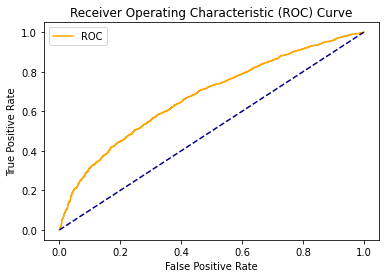

Test ROC
0.6891552031762851
Threshold value is: 0.7439241425612741


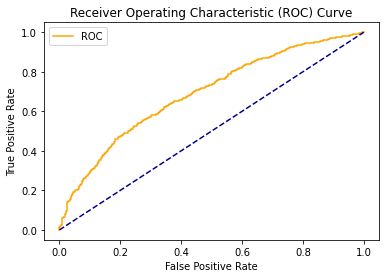


 
 =====================   Train Dataset    ======================
61.01379053298547
              precision    recall  f1-score   support

         0.0       0.40      0.68      0.50      1548
         1.0       0.82      0.58      0.68      3818

    accuracy                           0.61      5366
   macro avg       0.61      0.63      0.59      5366
weighted avg       0.70      0.61      0.63      5366



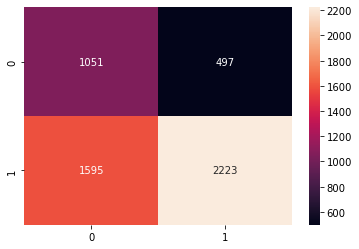

Accuracy of on training set: 0.71


 =====================   Test Dataset    =======================
59.75405254332029
              precision    recall  f1-score   support

         0.0       0.40      0.74      0.52       516
         1.0       0.84      0.54      0.66      1273

    accuracy                           0.60      1789
   macro avg       0.62      0.64      0.59      1789
weighted avg       0.71      0.60      0.62      1789



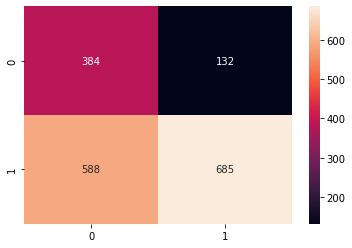

Accuracy of classifier on test set: 0.72


 =======================   Test-ROC    =========================
roc_auc = 0.6892


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.74418605 0.53809898]
average accuracy:  0.6411425126509436


In [45]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
# lda.fit(X_train, Y_train)
lda = cross_val(lda)

# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(lda, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(lda, X_test, Y_test)

pred = (lda.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(lda, X_train, Y_train, pred_train)
test_results(lda, X_test, Y_test, pred)

# ROC
ROC_results(lda, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(lda, Y_test, pred)


## Model 7- Gaussian Naive Bayes

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 1 on the test set: 0.7169459962756052, doublecheck: 0.7169459962756052
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 2 on the test set: 0.6983240223463687, doublecheck: 0.6983240223463687
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 3 on the test set: 0.707635009310987, doublecheck: 0.707635009310987
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 4 on the test set: 0.7039106145251397, doublecheck: 0.7039106145251397
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 5 on the test set: 0.7132216014897579, doublecheck: 0.7132216014897579
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 6 on the test set: 0.7150837988826816, doublecheck: 0.7150837988826816
Fitting 10 folds for each of 1

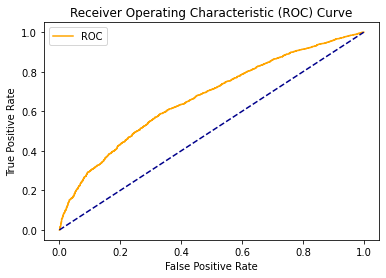

Test ROC
0.6845104343642863
Threshold value is: 0.7574700829611775


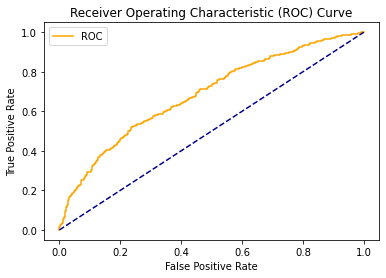


 
 =====================   Train Dataset    ======================
61.1442415206858
              precision    recall  f1-score   support

         0.0       0.40      0.67      0.50      1548
         1.0       0.81      0.59      0.68      3818

    accuracy                           0.61      5366
   macro avg       0.61      0.63      0.59      5366
weighted avg       0.69      0.61      0.63      5366



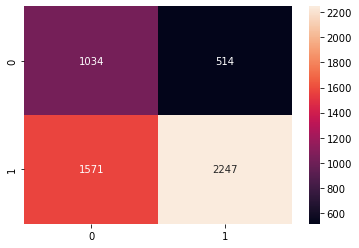

Accuracy of on training set: 0.71


 =====================   Test Dataset    =======================
59.250978200111796
              precision    recall  f1-score   support

         0.0       0.39      0.76      0.52       516
         1.0       0.84      0.52      0.65      1273

    accuracy                           0.59      1789
   macro avg       0.62      0.64      0.58      1789
weighted avg       0.71      0.59      0.61      1789



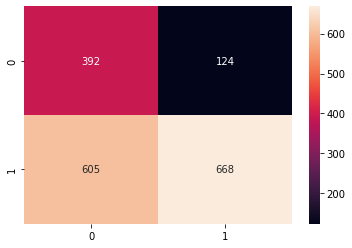

Accuracy of classifier on test set: 0.71


 =======================   Test-ROC    =========================
roc_auc = 0.6845


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.75968992 0.5247447 ]
average accuracy:  0.6422173100227139


In [46]:
gnb = GaussianNB()

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nbModel_grid = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
# nbModel_grid.fit(X_train, Y_train)
nbModel_grid = cross_val(nbModel_grid)

# best parameters
print(nbModel_grid.best_estimator_)

gnb = GaussianNB(priors=None, var_smoothing=1.0)
gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)
